## This document demonstrates how to import the python caliper module. The requirements for the Caliperpy package is listed below, copied and pasted directly from the TransCAD 9.0 GISDK help manual:

### TransCAD 9.0 Caliperpy installation instructions
Installing the Caliper Python Module
To program TransCAD in Python, you need:

TransCAD Version 9 or later
A Windows distribution of Python, version 3.x. At the time of writing, the latest Python version was 3.8. For example:
Anaconda Python for Windows, download at https://www.anaconda.com/download/
ActiveState Python, download at http://www.activestate.com/products/activepython
The Caliper Python Installer: C:\Program Files\TransCAD 2020\GISDK\Samples\Python\CaliperPy-v[yyyy-mm].win-amd64.exe
 

You can run the Caliper Python Installer once to install the CaliperPy package globally in your local Python program site-package folder.

 

The CaliperPy module use DCOM as a connection between TransCAD and Python. That means that DCOM must be enabled on your computer, and that the security settings for the DCOM objects "TransCAD.AutomationServer" and "TransCAD.AutomationServer (secondary)" must allow launch and access by users of your computer.

In [7]:
from shared_utils import geography_utils 
dk = caliperpy.TransCAD.connect()

### How to use

Enter in the highway line bin from the TRMG2 scenario you wish to summarize


In [10]:
'''
Change the path entry to the scenario you wish to summarize/analyze.

'''

path = "c:/Users/JacobFo/TRMG2_v0.2/scenarios/base_2016/output/networks/scenario_links.bin"
hwy_2016_g2 = dk.GetDataFrameFromBin(path)

hwy_2016_g2['Total_Transit_Flow'] = hwy_2016_g2['AB_Total_TransitFlow'] + hwy_2016_g2['BA_Total_TransitFlow']



### Load in TRMv6.2 2016

In [11]:
path = "c:/Users/JacobFo/OneDrive - City of Durham/Full Model Runs/Original TRMv6.2_2016 - Copy/"
inpFname =  os.path.join(path, "Input/Highway/Highway_Line.bin")
hwy_2016_v6 = dk.GetDataFrameFromBin(inpFname)

replace_nas = hwy_2016_v6

replace_nas.fillna(value = 0,inplace = True)

replace_nas['TotVMT'] = replace_nas['ABAMVMT']+replace_nas['ABMDVMT']+replace_nas['ABNTVMT']+replace_nas['ABPMVMT']+replace_nas['BAAMVMT']+replace_nas['BAMDVMT']+replace_nas['BANTVMT']+replace_nas['BAPMVMT']

replace_nas['TotVHT'] = replace_nas['ABAMVHT']+replace_nas['ABMDVHT']+replace_nas['ABNTVHT']+replace_nas['ABPMVHT']+replace_nas['BAAMVHT']+replace_nas['BAMDVHT']+replace_nas['BANTVHT']+replace_nas['BAPMVHT']



## How to use this tool:
aggregate_by_geo is basically a pivot + summarize function for any category in the TRMG2, making it easy to quickly summarize model outputs

example: VMT statistics by County:


In [6]:
group_cols = ["MPO"]
sum_cols = ["Total_Flow_Daily"]
mean_cols = ["Total_Flow_Daily"]



by_county = geography_utils.aggregate_by_geography(
    hwy_2016_g2,
    group_cols=group_cols,
    sum_cols = sum_cols,
    mean_cols=mean_cols,


)

by_county =   by_county.rename(columns={'Total_Flow_Daily_x': 'Sum Total Flow'})
by_county = by_county.rename(columns={'Total_Flow_Daily_y': 'Mean Flow'})
by_county

,MPO,Sum Total Flow,Mean Flow
0,CAMPO,194180089.684,2542.356
1,None,29152304.511,1274.529
2,DCHC,82426605.274,2930.828
3,None,NaN,NaN


In [3]:
group_cols = ["County"]
sum_cols = ["Total_Transit_Flow","Total_Flow_Daily"]


by_class = geography_utils.aggregate_by_geography(
  # replace_nas[replace_nas.COUNTY.notna()], 
    hwy_2016_g2,
    group_cols=group_cols,
    sum_cols = sum_cols


)

by_class

,County,Total_Flow_Daily,Total_Transit_Flow
0,Wake,172314595.946,2291254.297
1,Franklin,8323252.440,816.044
2,Johnston,19573688.226,3795.042
3,Chatham,5943315.381,21861.593
4,Durham,60486993.379,1753258.226
5,Nash,388466.360,41.788
6,Harnett,4795670.687,335.557
7,Orange,22718823.814,1142658.629
8,Alamance,5365310.614,8295.431
9,Granville,3324355.446,1282.284


In [4]:
import plotly
import plotly.express as px

In [5]:
import plotly.express as px

fig = px.bar(by_class,              # our dataframe
       x="County",         # x will be the 'key' column of the dataframe
       y="Total_Flow_Daily")

fig.show()

## Highway Assignment Checks TRMG2

Goal: Replicate the current TRMv6.2 summary tool and evaluation report's key metrics, while developing tool to replicate in TRMG2 format. 



 

# Vehicle Miles Traveled 

### Total VMT: TRMv6.2


In [12]:
vmt_v6_total = replace_nas['TotVMT'].sum()
vmt_v6_total

56927558.91335465

### Total VMT: TRMG2

In [13]:
vmt_g2_total=hwy_2016_g2['Total_VMT_Daily'].sum()
vmt_g2_total

59765994.53828005

Percent Difference: (G2 - v6.2)/ G2

In [14]:
((vmt_g2_total-vmt_v6_total)/vmt_g2_total)*100

4.749248543178484

### Total VMT by MPO: TRMv6.2

In [15]:
vmt_mpo_v6 = (
replace_nas 
    >>group_by(MPO = _.MPO)
    >>summarize(Total_VMT_v6 = _.TotVMT.sum())
)


vmt_mpo_v6 = (
vmt_mpo_v6
    >>arrange(_.MPO)
)


vmt_mpo_v6

,MPO,Total_VMT_v6
0,0,7864112.068
1,1,34546729.400
2,2,14516717.446


### Total VMT by MPO: TRMG2

- missing from TRMG2 line and TAZ layer, will need to circle around to tag

In [17]:
group_cols = ["MPO"]
sum_cols = ["Total_VMT_Daily"]
mean_cols = ["Total_VMT_Daily"]



by_mpo = geography_utils.aggregate_by_geography(
    hwy_2016_g2,
    group_cols=group_cols,
    sum_cols = sum_cols,
    mean_cols=mean_cols,


)

by_mpo =   by_mpo.rename(columns={'Total_VMT_Daily_x': 'Sum VMT Flow'})
by_mpo = by_mpo.rename(columns={'Total_VMT_Daily_y': 'Mean VMT'})
by_mpo

,MPO,Sum VMT Flow,Mean VMT
0,CAMPO,36385516.350,476.387
1,None,8466352.764,370.146
2,DCHC,14649339.953,520.884
3,None,NaN,NaN


### Total VMT by County

In [14]:

replace_nas['New_County'] = replace_nas['COUNTY'].str.lower()

vmt_county_v6 = (
replace_nas 
    >>group_by(County = _.New_County)
    >>summarize(Total_VMT_v6 = _.TotVMT.sum())
)

## add missing alamance to compare to TRMG2
vmt_county_v6.loc[len(vmt_county_v6.index)] = ['alamance', 0] 

vmt_county_v6 = (
vmt_county_v6
    >>arrange(_.County)
)




hwy_2016_g2['New_County'] = hwy_2016_g2['County'].str.lower()

vmt_county_g2 = (
hwy_2016_g2 
    >>group_by(County = _.New_County)
    >>summarize(Total_VMT_G2 =_.Total_VMT_Daily.sum()              
))

vmt_county_g2.loc[len(vmt_county_g2.index)] = ['external', 0] 

vmt_county_g2 = (
vmt_county_g2
    >>arrange(_.County)
)

county_comparison = pd.merge(vmt_county_v6, vmt_county_g2, on="County")
county_comparison['Difference'] = county_comparison['Total_VMT_G2']-county_comparison['Total_VMT_v6']
county_comparison['PctDifference'] = ((county_comparison['Total_VMT_G2']-county_comparison['Total_VMT_v6'])/county_comparison['Total_VMT_G2'])*100
county_comparison

,County,Total_VMT_v6,Total_VMT_G2,Difference,PctDifference
0,alamance,0.000,993303.300,993303.300,100.000
1,chatham,1887084.185,1908876.628,21792.443,1.142
2,durham,9579639.353,9896837.569,317198.216,3.205
3,external,145264.996,0.000,-145264.996,-inf
4,franklin,1482186.218,1562436.320,80250.102,5.136
5,granville,1311675.053,1176954.347,-134720.706,-11.447
6,harnett,1099687.873,1001411.441,-98276.432,-9.814
7,johnston,6071384.148,5819436.969,-251947.179,-4.329
8,nash,250834.738,199839.953,-50994.785,-25.518
9,orange,5220110.193,5146945.830,-73164.362,-1.422


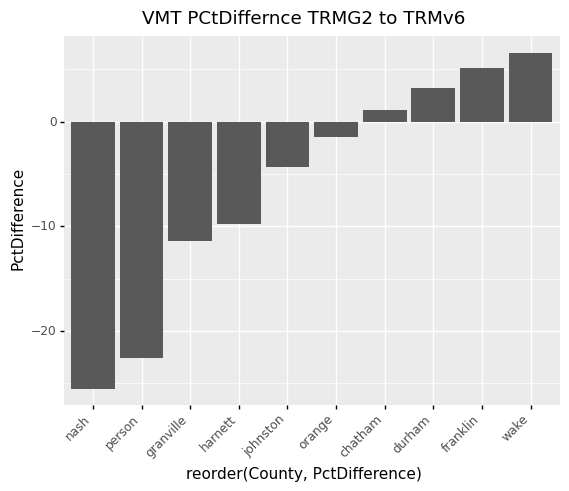

<ggplot: (152111915716)>

In [16]:
(
county_comparison
    >>arrange(-_.PctDifference)
    >>filter(_.County !="alamance")
    >>filter(_.County !="external")
    >>ggplot(aes('reorder(County, PctDifference)', "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("VMT PCtDiffernce TRMG2 to TRMv6")

)


# Vehicle Hours Traveled

### Total VHT: TRMv6.2

In [17]:
vht_v6_total = replace_nas['TotVHT'].sum()
vht_v6_total

1415882.0878761539

### Total VHT: TRMG2

In [18]:
vht_g2_total = hwy_2016_g2['Total_VHT_Daily'].sum()
vht_g2_total

1287044.2371000464

### Total VHT by County

In [19]:
vht_county_v6 = (
replace_nas 
    >>group_by(County = _.New_County)
    >>summarize(Total_VHT_v6 = _.TotVHT.sum())
)

## add missing alamance to compare to TRMG2
vht_county_v6.loc[len(vht_county_v6.index)] = ['alamance', 0] 

vht_county_v6 = (
vht_county_v6
    >>arrange(_.County)
)


hwy_2016_g2['New_County'] = hwy_2016_g2['County'].str.lower()

vht_county_g2 = (
hwy_2016_g2 
    >>group_by(County = _.New_County)
    >>summarize(Total_VHT_G2 =_.Total_VHT_Daily.sum()              
))

vht_county_g2.loc[len(vmt_county_g2.index)] = ['external', 0] 

vht_county_g2 = (
vht_county_g2
    >>arrange(_.County)
)

county_comparison = pd.merge(vht_county_v6, vht_county_g2, on="County")
county_comparison['Difference'] = county_comparison['Total_VHT_G2']-county_comparison['Total_VHT_v6']
county_comparison['PctDifference'] = ((county_comparison['Total_VHT_G2']-county_comparison['Total_VHT_v6'])/county_comparison['Total_VHT_G2'])*100

county_comparison


,County,Total_VHT_v6,Total_VHT_G2,Difference,PctDifference
0,alamance,0.000,25916.825,25916.825,100.000
1,chatham,38290.331,36496.280,-1794.051,-4.916
2,durham,246640.255,222062.404,-24577.851,-11.068
3,external,3321.714,0.000,-3321.714,-inf
4,franklin,32199.822,31519.267,-680.555,-2.159
5,granville,25698.701,22038.494,-3660.207,-16.608
6,harnett,24472.330,21624.691,-2847.638,-13.168
7,johnston,124541.795,108030.821,-16510.975,-15.284
8,nash,4109.596,3125.565,-984.031,-31.483
9,orange,122548.292,111874.426,-10673.866,-9.541


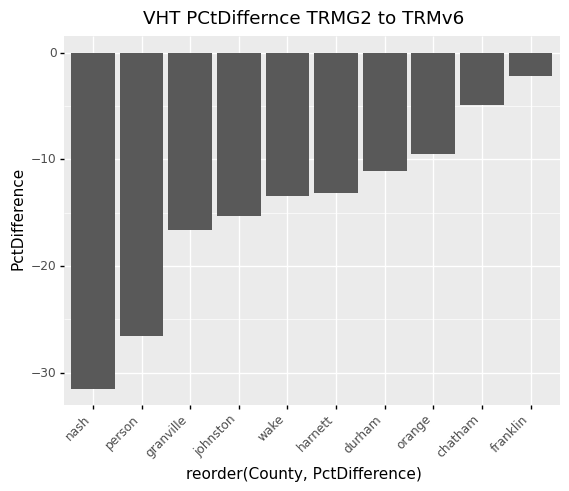

<ggplot: (152068902750)>

In [20]:

(
county_comparison
    >>arrange(-_.PctDifference)
    >>filter(_.County !="alamance")
    >>filter(_.County !="external")
    >>ggplot(aes('reorder(County, PctDifference)', "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("VHT PCtDiffernce TRMG2 to TRMv6")

)


# Total Daily Volume - All Links


### Total Daily Volume: TRMv6.2

In [21]:
tot_vol_v6_total = replace_nas['ToTDlyVol'].sum()
tot_vol_v6_total

186392885.39225224

### Total Daily Volume: TRMG2

In [22]:
tot_vol_g2_total = hwy_2016_g2['Total_Flow_Daily'].sum()
tot_vol_g2_total

306663903.1572029

### Total Daily Volume by County

In [23]:
tot_vol_county_v6 = (
replace_nas 
    >>group_by(County = _.New_County)
    >>summarize(Total_Flow_v6 = _.ToTDlyVol.sum())
)

## add missing alamance to compare to TRMG2
tot_vol_county_v6.loc[len(tot_vol_county_v6.index)] = ['alamance', 0] 

tot_vol_county_v6 = (
tot_vol_county_v6
    >>arrange(_.County)
)


hwy_2016_g2['New_County'] = hwy_2016_g2['County'].str.lower()

tot_vol_county_g2 = (
hwy_2016_g2 
    >>group_by(County = _.New_County)
    >>summarize(Total_Flow_G2 =_.Total_Flow_Daily.sum()              
))

tot_vol_county_g2.loc[len(tot_vol_county_g2.index)] = ['external', 0] 

tot_vol_county_g2 = (
tot_vol_county_g2
    >>arrange(_.County)
)

county_comparison = pd.merge(tot_vol_county_v6, tot_vol_county_g2, on="County")
county_comparison['Difference'] = county_comparison['Total_Flow_G2']-county_comparison['Total_Flow_v6']
county_comparison['PctDifference'] = ((county_comparison['Total_Flow_G2']-county_comparison['Total_Flow_v6'])/county_comparison['Total_Flow_G2'])*100

county_comparison


,County,Total_Flow_v6,Total_Flow_G2,Difference,PctDifference
0,alamance,0.000,5365310.614,5365310.614,100.000
1,chatham,2498666.222,5943315.381,3444649.158,57.958
2,durham,43217816.601,60486993.379,17269176.777,28.550
3,external,676773.888,0.000,-676773.888,-inf
4,franklin,2665561.592,8323252.440,5657690.847,67.975
5,granville,1775753.358,3324355.446,1548602.089,46.584
6,harnett,1930055.644,4795670.687,2865615.042,59.754
7,johnston,10281901.428,19573688.226,9291786.798,47.471
8,nash,249296.364,388466.360,139169.997,35.825
9,orange,15895967.235,22718823.814,6822856.578,30.032


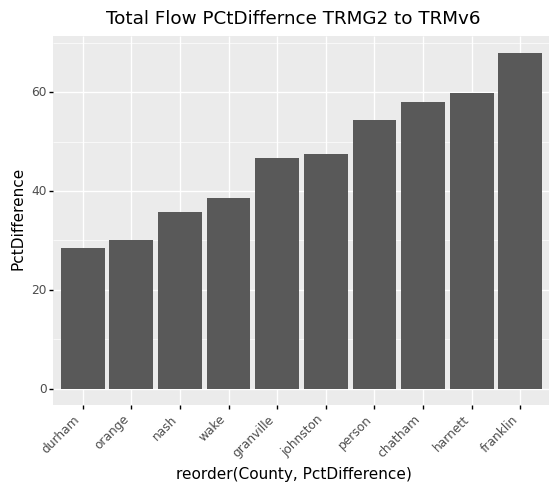

<ggplot: (152072254546)>

In [24]:

(
county_comparison
    >>arrange(-_.PctDifference)
    >>filter(_.County !="alamance")
    >>filter(_.County !="external")
    >>ggplot(aes('reorder(County, PctDifference)', "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("Total Flow PCtDiffernce TRMG2 to TRMv6")

)


# Total Daily Volume - Links with Counts

### Total Daily Volume: TRMv6.2

In [34]:
inpFname =  os.path.join(path, "EvalModule/TRM6_Count_2016_Observed.bin")
count = dk.GetDataFrameFromBin(inpFname)

temp = (
count 
    >>select(_.ID, _.Daily_Counts)
)

temp = pd.merge(replace_nas, temp)

hwy_2016_v6_counts = (
temp
    >>filter(_.Daily_Counts > 0)
)

tot_vol_v6_total = hwy_2016_v6_counts['ToTDlyVol'].sum()
tot_vol_v6_total



52528713.675038055

### Total Daily Volume: TRMG2

In [35]:
hwy_2016_g2_counts = (
hwy_2016_g2
    >>filter(_.DailyCount>0)
)

tot_vol_g2_total = hwy_2016_g2_counts['Total_Flow_Daily'].sum()
tot_vol_g2_total

56116720.94354267

Percent Difference

In [36]:
((tot_vol_g2_total-tot_vol_v6_total)/tot_vol_g2_total)*100

6.393829162103747

In [37]:
tot_vol_county_v6 = (
hwy_2016_v6_counts 
    >>group_by(County = _.New_County)
    >>summarize(Total_Flow_v6 = _.ToTDlyVol.sum(),
               Total_Counts_v6 = _.Daily_Counts.sum())
    >>mutate(PctDifference = (_.Total_Flow_v6 - _.Total_Counts_v6)/_.Total_Flow_v6*100)
)


hwy_2016_g2_counts['New_County'] = hwy_2016_g2_counts['County'].str.lower()

tot_vol_county_g2 = (
hwy_2016_g2_counts 
    >>group_by(County = _.New_County)
    >>summarize(Total_Flow_G2 =_.Total_Flow_Daily.sum(),
                Total_Counts_G2 = _.DailyCount.sum())
    >>mutate(PctDifference = (_.Total_Flow_G2 - _.Total_Counts_G2)/_.Total_Flow_G2*100)
)


tot_vol_county_g2.loc[len(tot_vol_county_g2.index)] = ['external', 0,0,0] 

tot_vol_county_g2 = (
tot_vol_county_g2
    >>arrange(_.County)
)

county_comparison = pd.merge(tot_vol_county_v6, tot_vol_county_g2, on="County")

county_comparison['Difference'] = county_comparison['Total_Flow_G2']-county_comparison['Total_Flow_v6']
county_comparison['PctDifference'] = ((county_comparison['Total_Flow_G2']-county_comparison['Total_Flow_v6'])/county_comparison['Total_Flow_G2'])*100

tot_flow_county = (
county_comparison
    >>select(_.County, _.Total_Flow_v6, _.Total_Flow_G2, _.PctDifference)
)
tot_flow_county

<ipython-input-37-bde943d44b36>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,County,Total_Flow_v6,Total_Flow_G2,PctDifference
0,chatham,845870.512,912262.988,7.278
1,durham,12016011.959,12969703.995,7.353
2,external,104807.179,0.000,-inf
3,franklin,979763.419,1020690.377,4.010
4,granville,674119.029,628106.699,-7.326
5,harnett,728257.696,652223.976,-11.658
6,johnston,3509072.787,3436414.086,-2.114
7,nash,124308.538,66200.312,-87.776
8,orange,4007723.588,3925944.749,-2.083
9,person,644518.160,527404.481,-22.206


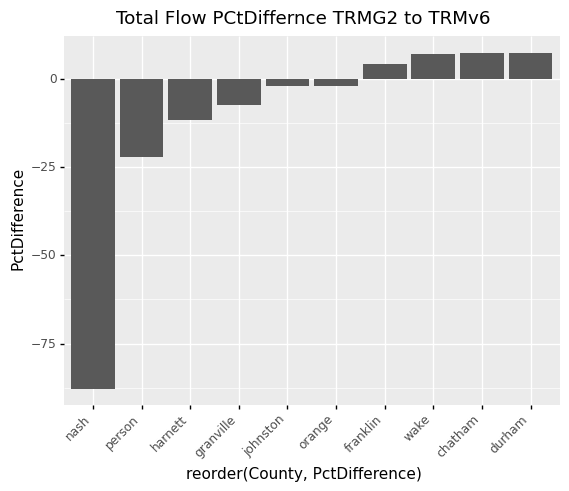

<ggplot: (152075577188)>

In [38]:

(
tot_flow_county
    >>arrange(-_.PctDifference)
    >>filter(_.County !="alamance")
    >>filter(_.County !="external")
   # >>ggplot(aes("County", "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("Total Flow PCtDiffernce TRMG2 to TRMv6")
     >>ggplot(aes('reorder(County, PctDifference)', "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("Total Flow PCtDiffernce TRMG2 to TRMv6")
)


# Total Flow by Facility Type

## TRMv6.2

In [39]:
hwy_2016_v6_counts['FCGroup_Tag'] = case_when(hwy_2016_v6_counts, {
    _.FCGROUP ==1 : "Freeway",
    _.FCGROUP ==2 : "Major Arterial",
    _.FCGROUP ==3: "Minor Arterial",
    _.FCGROUP ==4: "Collector",
    _.FCGROUP ==5: "Local",
    True: "CC"
})

tot_vol_fcgroup_v6 = (
hwy_2016_v6_counts 
    >>group_by(_.FCGroup_Tag)
    >>filter(_.FCGroup_Tag !="CC")
    >>summarize(Total_Flow_v6 = _.ToTDlyVol.sum(),
               Total_Counts_v6 = _.Daily_Counts.sum())
    >>mutate(PctDifference = (_.Total_Flow_v6 - _.Total_Counts_v6)/_.Total_Flow_v6*100)
)
tot_vol_fcgroup_v6

,FCGroup_Tag,Total_Flow_v6,Total_Counts_v6,PctDifference
0,Collector,6441993.944,6623550,-2.818
1,Freeway,14257957.000,14084500,1.217
2,Local,4735795.867,4655830,1.689
3,Major Arterial,13835060.618,15284820,-10.479
4,Minor Arterial,13151478.378,13397660,-1.872


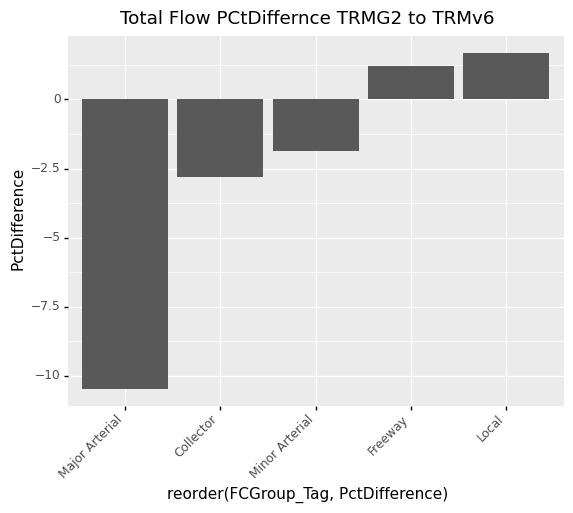

<ggplot: (152098400220)>

In [40]:
(
tot_vol_fcgroup_v6
    >>ggplot(aes('reorder(FCGroup_Tag, PctDifference)', "PctDifference"))+geom_bar(stat='identity', position='dodge')+ theme(axis_text_x = element_text(angle = 45 , hjust=1))
            +ggtitle("Total Flow PCtDiffernce TRMG2 to TRMv6")
)


## TRMG2

In [41]:
##Recreate count_comparison_by_ft_and_at.csv 


count_comparison_by_ft_and_at = (
hwy_2016_g2 
    >>filter(_.HCMType !="CC")
    >>filter(_.DailyCount>0)
    >>group_by(_.HCMType)
    >>summarize(n = _.DailyCount.count(),
                TotalVolume =_.Total_Flow_Daily.sum(),
                TotalCounts = _.DailyCount.sum())
    >>mutate(PctDifference = (_.TotalVolume - _.TotalCounts)/_.TotalVolume*100)
    >>arrange(-_.PctDifference)
  

)

count_comparison_by_ft_and_at

,HCMType,n,TotalVolume,TotalCounts,PctDifference
7,TLHighway,79,814139.459,716100,12.042
2,Freeway,359,14787504.962,14060257,4.918
4,MLHighway,115,2394673.483,2297000,4.079
3,Local,459,1217696.350,1168850,4.011
5,MajorArterial,877,19678396.453,19336397,1.738
0,Arterial,1605,13139758.068,13623523,-3.682
6,MajorCollector,275,1300728.737,1366060,-5.023
1,Collector,828,2644544.037,2894841,-9.465


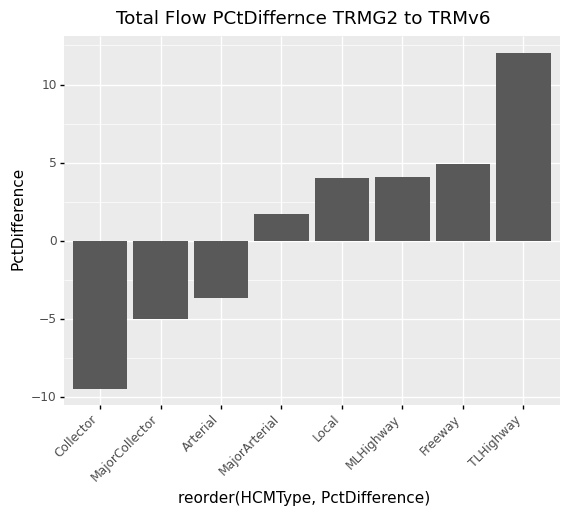

<ggplot: (152080372435)>

In [42]:
(
count_comparison_by_ft_and_at
    >>ggplot(aes('reorder(HCMType, PctDifference)', "PctDifference"))+geom_bar(stat='identity', position='dodge')+ theme(axis_text_x = element_text(angle = 45 , hjust=1))
            +ggtitle("Total Flow PCtDiffernce TRMG2 to TRMv6")
)
